In [15]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [17]:
import numpy as np
import pandas as pd

# CSV 파일의 컬럼 이름 지정 (첫 번째 컬럼은 버릴 값이므로 "NaN"으로 명명)
names = ["NaN", "user_id", "activity", "timestamp", "x_axis", "y_axis", "z_axis"]

# CSV 파일 읽기 (header 없이, 첫 줄은 skip)
data = pd.read_csv("/Users/ohheungchan/workspace/AI_Study/paperwork/WISDM.csv",
                   header=None, names=names, skiprows=1)

# "NaN" 컬럼 제거
df = data.drop('NaN', axis=1)

# 'z_axis' 컬럼을 문자열로 변환 후 세미콜론(;) 제거
df["z_axis"] = df["z_axis"].astype(str).str.replace(';', '', regex=True)

# 문자열 데이터를 float으로 변환 (에러 발생 시 NaN으로 처리)
df["timestamp"] = pd.to_numeric(df["timestamp"], errors='coerce')
df["x_axis"]    = pd.to_numeric(df["x_axis"], errors='coerce')
df["y_axis"]    = pd.to_numeric(df["y_axis"], errors='coerce')
df["z_axis"]    = pd.to_numeric(df["z_axis"], errors='coerce')

# 결측치가 있는 행 제거
df.dropna(axis=0, how='any', inplace=True)

# 결과 확인
print(df.head())
print("DataFrame shape:", df.shape)

   user_id activity       timestamp    x_axis     y_axis    z_axis
0       33  Jogging  49105962326000 -0.694638  12.680544  0.503953
1       33  Jogging  49106062271000  5.012288  11.264028  0.953424
2       33  Jogging  49106112167000  4.903325  10.882658 -0.081722
3       33  Jogging  49106222305000 -0.612916  18.496431  3.023717
4       33  Jogging  49106332290000 -1.184970  12.108489  7.205164
DataFrame shape: (1098203, 6)


In [18]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import OneHotEncoder  # CrossEntropyLoss는 정수형 라벨을 사용하므로 OneHot은 필요없음

#############################################
# 1. 데이터 전처리 및 레이블 인코딩
#############################################
# df는 이미 'x_axis', 'y_axis', 'z_axis', 'activity' 컬럼을 가진 DataFrame이라고 가정합니다.
le = LabelEncoder()
df['ActivityEncoded'] = le.fit_transform(df['activity'])
num_classes = len(le.classes_)
print("활동 클래스:", le.classes_)


활동 클래스: ['Downstairs' 'Jogging' 'Sitting' 'Standing' 'Upstairs' 'Walking']


In [19]:
df.activity.value_counts()

activity
Walking       424397
Jogging       342176
Upstairs      122869
Downstairs    100427
Sitting        59939
Standing       48395
Name: count, dtype: int64

<Axes: xlabel='activity', ylabel='count'>

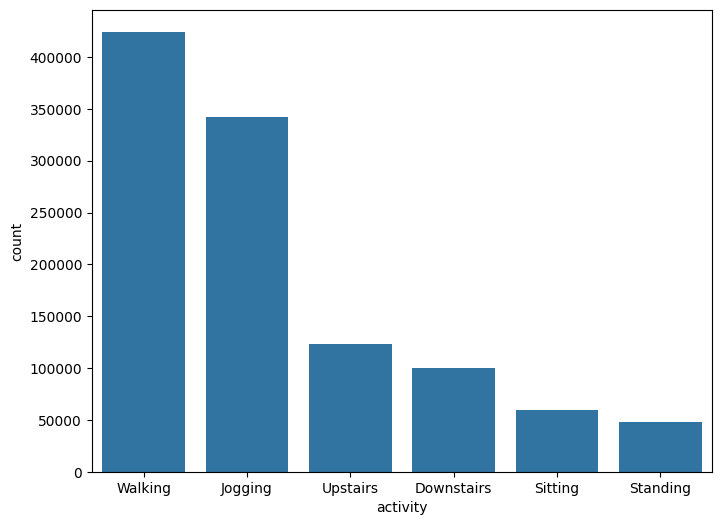

In [20]:
plt.figure(figsize=(8, 6))
sns.countplot(x = "activity", data = df, order = df.activity.value_counts().index)
     

In [21]:
#############################################
# 2. 시계열 데이터 세그먼테이션 함수 정의
#############################################
def create_dataset(X, y, time_steps=1, step=1):
    """
    X: 센서 데이터가 담긴 DataFrame (예: ["x_axis", "y_axis", "z_axis"])
    y: 라벨(인코딩된 값)이 담긴 Series (예: df["ActivityEncoded"])
    time_steps: 각 시퀀스(윈도우)의 길이 (예: 200)
    step: 윈도우 생성 시 이동 간격 (예: 40)
    """
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        # i부터 i+time_steps까지의 센서 데이터를 numpy 배열로 변환
        v = X.iloc[i:(i + time_steps)].values
        # 해당 구간의 라벨들을 선택하고, 다수결(mode)로 대표 라벨 결정
        window_labels = y.iloc[i:(i + time_steps)]
        mode_result = stats.mode(window_labels)
        mode_label = mode_result.mode
        # 만약 mode_label이 배열이면 첫 번째 원소 선택
        if isinstance(mode_label, np.ndarray):
            mode_label = mode_label[0]
        Xs.append(v)
        ys.append(mode_label)
    return np.array(Xs), np.array(ys).reshape(-1, 1)

In [22]:

#############################################
# 3. 시퀀스 데이터 생성 및 데이터 분할
#############################################
TIME_STEPS = 200  # 각 윈도우(시퀀스)의 길이
STEP = 40         # 윈도우 생성 시 이동 간격

X_data, y_data = create_dataset(df[["x_axis", "y_axis", "z_axis"]], df["ActivityEncoded"],
                                time_steps=TIME_STEPS, step=STEP)

# 전체 데이터에서 test set 분리 (stratify 옵션으로 클래스 비율 유지)
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.2, random_state=42, stratify=y_data
)
# train set에서 validation set 분리 (전체의 20%를 validation으로 사용)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print("Train shape:", X_train.shape, y_train.shape)
print("Validation shape:", X_val.shape, y_val.shape)
print("Test shape:", X_test.shape, y_test.shape)


Train shape: (17568, 200, 3) (17568, 1)
Validation shape: (4392, 200, 3) (4392, 1)
Test shape: (5491, 200, 3) (5491, 1)


In [23]:
#############################################
# 4. PyTorch DataLoader 준비
#############################################
import torch
from torch.utils.data import DataLoader, TensorDataset

def prepare_loader(X, y, batch_size=64):
    # CNN 모델 입력은 (batch, channels, length) → 변환: (N, window_size, 3) → (N, 3, window_size)
    X_tensor = torch.tensor(X, dtype=torch.float32).permute(0, 2, 1)
    # y는 정수형 라벨, shape (N,1) -> squeeze하여 (N,)
    y_tensor = torch.tensor(y, dtype=torch.long).squeeze()
    dataset = TensorDataset(X_tensor, y_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return loader

train_loader = prepare_loader(X_train, y_train, batch_size=64)
val_loader = prepare_loader(X_val, y_val, batch_size=64)
test_loader = prepare_loader(X_test, y_test, batch_size=64)


In [24]:

#############################################
# 5. 간단한 1D CNN 분류기 정의
#############################################
import torch.nn as nn
import torch.optim as optim

# Device 설정 (MPS, CUDA 또는 CPU)
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using device: MPS (Apple GPU)")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

class SimpleCNN(nn.Module):
    def __init__(self, num_classes, window_size=200):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * (window_size // 4), 128)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

Using device: MPS (Apple GPU)


In [26]:
#############################################
# 6. 모델 학습 및 평가
#############################################
num_epochs = 10  # 학습 에폭 수
window_size=200
model = SimpleCNN(num_classes=num_classes, window_size=window_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("\n=== 모델 학습 시작 ===")
# 에폭별 손실과 정확도를 저장할 리스트
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_train = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == y_batch)
        total_train += y_batch.size(0)
    
    epoch_train_loss = running_loss / total_train
    epoch_train_acc = running_corrects.float() / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc.item())
    
    # Validation Phase
    model.eval()
    val_running_loss = 0.0
    val_running_corrects = 0
    total_val = 0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val = X_val.to(device)
            y_val = y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_running_loss += loss.item() * X_val.size(0)
            _, preds = torch.max(outputs, 1)
            val_running_corrects += torch.sum(preds == y_val)
            total_val += y_val.size(0)
    epoch_val_loss = val_running_loss / total_val
    epoch_val_acc = val_running_corrects.float() / total_val
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc.item())
    
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")



=== 모델 학습 시작 ===
Epoch 1/10, Train Loss: 0.4457, Train Acc: 0.8377, Val Loss: 0.2523, Val Acc: 0.9110
Epoch 2/10, Train Loss: 0.1812, Train Acc: 0.9374, Val Loss: 0.1843, Val Acc: 0.9333
Epoch 3/10, Train Loss: 0.0995, Train Acc: 0.9665, Val Loss: 0.1210, Val Acc: 0.9606
Epoch 4/10, Train Loss: 0.0632, Train Acc: 0.9795, Val Loss: 0.1120, Val Acc: 0.9638
Epoch 5/10, Train Loss: 0.0388, Train Acc: 0.9875, Val Loss: 0.1536, Val Acc: 0.9485
Epoch 6/10, Train Loss: 0.0257, Train Acc: 0.9919, Val Loss: 0.1229, Val Acc: 0.9608
Epoch 7/10, Train Loss: 0.0163, Train Acc: 0.9953, Val Loss: 0.1029, Val Acc: 0.9690
Epoch 8/10, Train Loss: 0.0343, Train Acc: 0.9894, Val Loss: 0.1084, Val Acc: 0.9699
Epoch 9/10, Train Loss: 0.0151, Train Acc: 0.9955, Val Loss: 0.1297, Val Acc: 0.9606
Epoch 10/10, Train Loss: 0.0101, Train Acc: 0.9968, Val Loss: 0.1582, Val Acc: 0.9656


In [27]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).squeeze()  # 만약 y_batch가 (batch_size, 1)이라면
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

accuracy = 100 * correct / total
print(f"테스트 정확도: {accuracy:.2f}%")

테스트 정확도: 96.59%


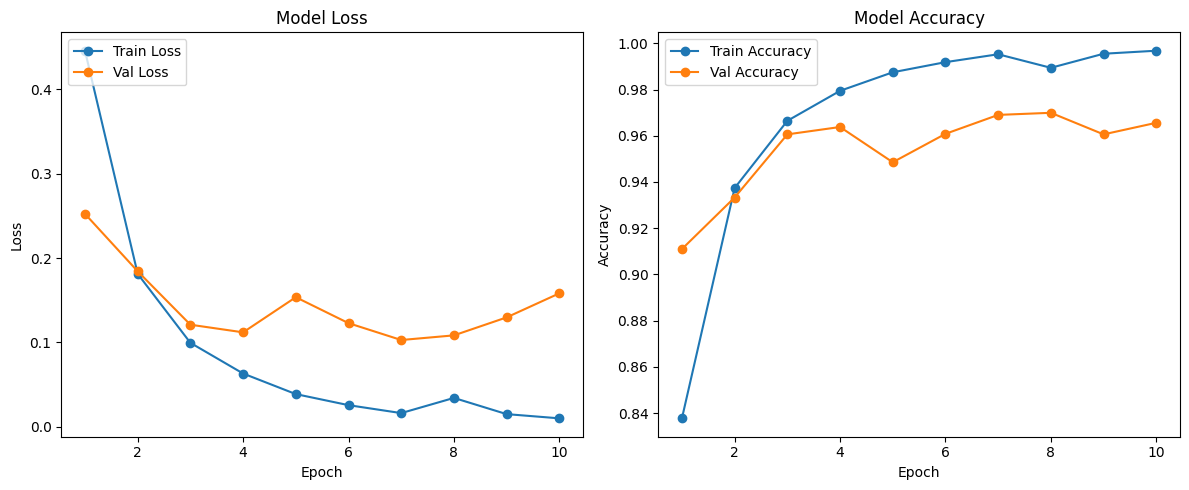

In [28]:
# 학습 및 검증 결과 플롯팅
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# 손실 플롯
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, marker='o', label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, marker='o', label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

# 정확도 플롯
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, marker='o', label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, marker='o', label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

F1 Score (weighted): 0.965234973888006
Accuracy: 0.9659442724458205
Classification Report:
              precision    recall  f1-score   support

     Walking       0.92      0.87      0.90       503
     Jogging       0.97      0.99      0.98      1710
    Upstairs       0.99      0.98      0.99       300
  Downstairs       0.98      0.98      0.98       242
     Sitting       0.93      0.85      0.88       613
    Standing       0.97      1.00      0.99      2123

    accuracy                           0.97      5491
   macro avg       0.96      0.95      0.95      5491
weighted avg       0.97      0.97      0.97      5491



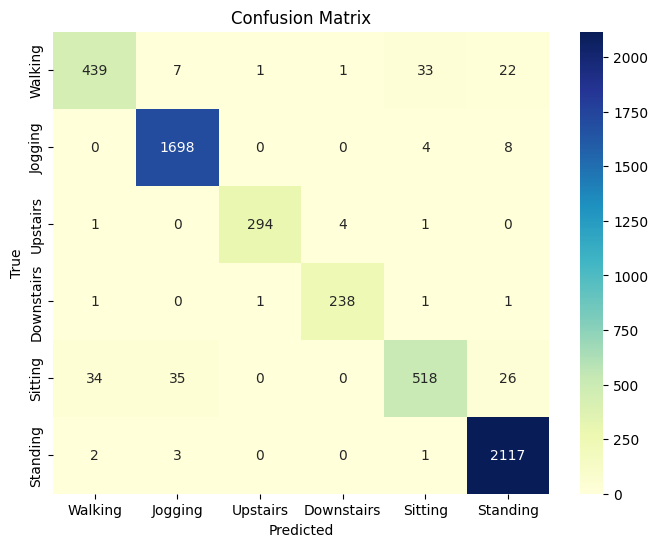

In [29]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# LABELS는 클래스 이름을 지정합니다.
LABELS = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']

# 모델을 평가 모드로 전환
model.eval()

# 전체 test 데이터에 대해 예측값과 정답을 모읍니다.
all_preds = []
all_true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        outputs = model(X_batch)
        # 각 샘플에 대해 가장 높은 확률을 가진 클래스 인덱스 선택
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_true.extend(y_batch.cpu().numpy())

# 혼동 행렬 계산
cm = confusion_matrix(all_true, all_preds)

# 평가 지표 출력
print("F1 Score (weighted):", f1_score(all_true, all_preds, average='weighted'))
print("Accuracy:", accuracy_score(all_true, all_preds))
print("Classification Report:")
print(classification_report(all_true, all_preds, target_names=LABELS))

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()